In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_circles, make_blobs
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# Support Vector Machines (SVMs) 

## Overview

In this tutorial, we will explore Support Vector Machines (SVMs) and understand how different kernels behave under different hyperparameter settings.

The main goals of this notebook are:
- Learn how to use the plug-and-play models implemented in the Python package scikit-learn
- Explore the power of the parameter `C`.
- Explore the power of different kernels with different parameter `gamma`.

## Datasets

In this notebook we will be using the following three datasets:
- Dataset A: 2-dimensional 2-classes isotropic Gaussian blobs. The samples for each class are generated from a gaussian distribution with a certain mean and standard deviation. This dataset is linearly separable.
- Dataset B: 2-dimensional 2-classes isotropic Gaussian blobs. The samples for each class are generated from a gaussian distribution with a certain mean and standard deviation. This dataset is not linearly separable.
- Dataset C: 2-dimensional 2-classes circles. Samples for each class are generated from circles with a certain radius plus some noise. This dataset corresponds to a non-linear problem.
- Dataset D: 2-dimensional 3-classes isotropic Gaussian blobs. The samples for each class are generated from a gaussian distribution with a certain mean and standard deviation. This dataset is linearly separable.

In [2]:
# Function to plot a dataset
def plot_dataset(X, y, title, axes=None):
    if axes is None:
        axes = plt.gca()
    y_zero = y==0
    y_one = y==1
    
    axes.scatter(X[y_zero, 0], X[y_zero, 1], color="red", label="Class 0")
    axes.scatter(X[y_one, 0], X[y_one, 1], color="blue", label="Class 1")
    axes.set_xlabel("x1")
    axes.set_ylabel("x2")
    axes.set_title(title)
    axes.legend()

In [3]:
# Fix seed
np.random.seed(5)
n_samples = 100

# Dataset A
X_blobs1, y_blobs1 = make_blobs(n_samples=n_samples, centers=[(-1, -1), (1, 1)], cluster_std=0.45)
X_blobs1_test, y_blobs1_test = make_blobs(n_samples=1000, centers=[(-1, -1), (1, 1)], cluster_std=0.45)


# Dataset B
X_blobs2, y_blobs2 = make_blobs(n_samples=2*n_samples, centers=[(-1, -1), (1, 1)], cluster_std=0.8)
X_blobs2_test, y_blobs2_test = make_blobs(n_samples=500, centers=[(-1, -1), (1, 1)], cluster_std=0.8)


# Dataset C
X_circles, y_circles = make_circles(n_samples=n_samples, factor=.1, noise=.05)
X_circles_test, y_circles_test = make_circles(n_samples=500, factor=.1, noise=.05)

# Dataset D
X_blobs3, y_blobs3 = make_blobs(n_samples=n_samples, n_features=2, centers=[(-1, -1), (1, 1), (2, -1)], cluster_std=0.5)
X_blobs3_test, y_blobs3_test = make_blobs(n_samples=500, centers=[(-1, -1), (1, 1), (2, -1)], cluster_std=0.5)


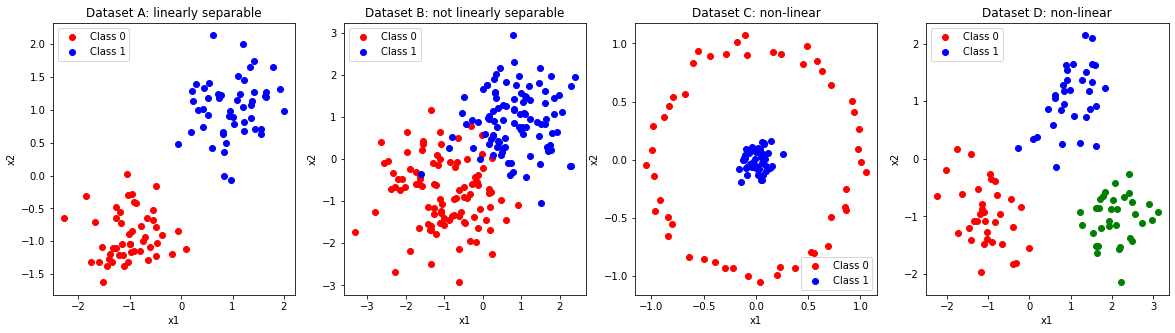

In [4]:
# Ploting the datasets
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

# 2 classes
plot_dataset(X_blobs1, y_blobs1, title="Dataset A: linearly separable", axes=ax[0])
plot_dataset(X_blobs2, y_blobs2, title="Dataset B: not linearly separable", axes=ax[1])
plot_dataset(X_circles, y_circles, title="Dataset C: non-linear", axes=ax[2])

# 3 classes
y_two = y_blobs3==2
plot_dataset(X_blobs3, y_blobs3, title="Dataset D: non-linear", axes=ax[3])
plt.scatter(X_blobs3[y_two, 0], X_blobs3[y_two, 1], color="green", axes=ax[3])
_ = ax[3].legend();

## How to

Throughout this notebook we will be analyzing SVM classifiers with different configurations (i.e, parameters and kernels) by computing the test error of the classifier(s) and plotting their classification boundary. Lets start with looking at the functions that perform this:

- Compute the test error of a classifier with a function called `test_error`. The inputs to this function are the ground truth (correct) label `y_true` and the predicted labels by the classifier `y_pred`.

In [5]:
def test_error(y_true, y_pred):
    """Test error for SVC for classification"""
    ## TODO: Implement the function that computes test error
    pass

- Plot the decision boundary of a trained 2D Support Vector Classifier (SVC) model with a function called `plot_svc_decision_function` which takes in the SVC `model` as input. The function should also plot the margin and have the option to plot the support vectors (`plot_support`)

In [6]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()  # If no figure handle is provided, it opens the current figure
    
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # Create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30) # 30 points in the grid axis
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x) # We create a grid with the x, y coordinates defined above
    
    # From the grid to a list of (x, y) values.
    # Check Numpy help for ravel()
    
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    
    # Method of SVC - Evaluates the decision function for the samples in X.
    ## TODO: Get decision boundary
    
    ## TODO: Plot the deciison boundary and margins
    # In levels we provide a list of floating point numbers indicating
    # the level curves to draw, in increasing order; e.g., to draw just the zero contour pass
    
    
    # Plot the support vectors
    if plot_support:
        ## TODO: Plot the support vectors
        pass
        
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

# 1. Linearly separable data

We start with looking at dataset A

## Maximum Margin Hyperplane

A maximum margin hyperplane $(w, b)$ for a linearly separable set of training data $(x_i, y_i)_{i=1}^n$ is defined as 
$$\underset{\mathbf{w} \in \mathbb{R}^d, b \in \mathbb{R}}{\max \min} \{\| x - x_i\| \mid \langle w,x \rangle + b = 0, x \in \mathbb{R}^d, i=1, ..., n \}$$

where we optimize over all $(w, b)$ such that $y_i(\langle w, x_i \rangle + b) > 0$.

So, what is the best separating hyperplane? The one that maximizes the distance to the closest data point from both classes. We say it is the hyperplane with maximum margin.

A hyperplane is defined through $\mathbf{w}, b$ as a set of points such that $\mathcal{H} = \{\mathbf{x} \mid \mathbf{w}^T \mathbf{x} + b = 0\}$. We define the margin as the distance from the hyperplane to the closest point across both classes. 

A linear classifier (our hyperplane) takes decision according to:
$$\hat{y}(x) = \operatorname{sign}(\langle w, x \rangle + b)$$


**Consider an example**

You have the following three hyperplanes/decision boundaries given. You can see them as three sugestions on how to take decisions on the given dataset. Can you tell which suggestion is the best? How would you proceed to analyze them Let's take a look at it together, step by step.

These are our three hyperplanes (classifiers) for the 2D dataset.

- Classifier A: $w = (1, 1), b=0$
- Classifier B: $w = (1, 0.3), b=0$
- Classifier C: $w = (0.5, 1.6), b=0$

We will now take a closer look.

- 1.1 Let's begin with plotting how the given hyperplanes split the training data. 

     (a) Create a function `get_decision_boundary` that computes the decision boundary given weights $w$ and bias $b$ for a given vector `X`. 

     (b) Print all three hyperplanes

Questions
- What do you observe?
- Can you tell from this plot which of the classifiers is the best?

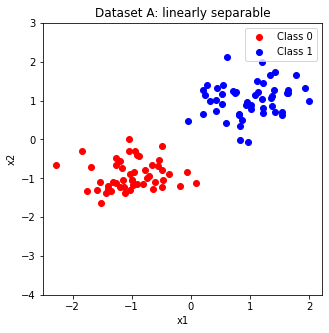

In [7]:
## TODO: Specify weights, bias as given
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

def get_decision_boundary(w, b, X):
    ## TODO: Implement the function that gets the decision boundary
    pass

xfit = np.linspace(-3, 3)
ax.set_ylim(-4, 3)

## TODO: Plot all three decision boundary

plot_dataset(X_blobs1, y_blobs1, title="Dataset A: linearly separable", axes=ax)

- 1.2 Assume a fourth candidate D shows up with $w = (2, 2)$ and $b=0$. Before plotting it, can you say if it will be better or worse than the other candidates?

Now plot it together with the other candidates. What do you observe?

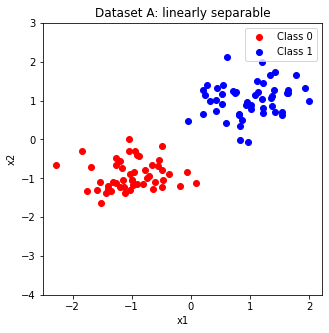

In [8]:
## TODO: Specify scaled weights and bias as given. 

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
## TODO: Plot all three decision boundaries

ax.set_ylim(-4, 3)
plot_dataset(X_blobs1, y_blobs1, title="Dataset A: linearly separable", axes=ax)

- 1.3 How do we find the best classifier candidate then? From the lecture, we know that a **maximum hyperplane** is hyperplane which correctly classifies the data and has **maximum distance/margin** to the data. Can you draw around each decision boundary a *margin* with some width up to the nearest point? What do you observe?

[None, None, None]

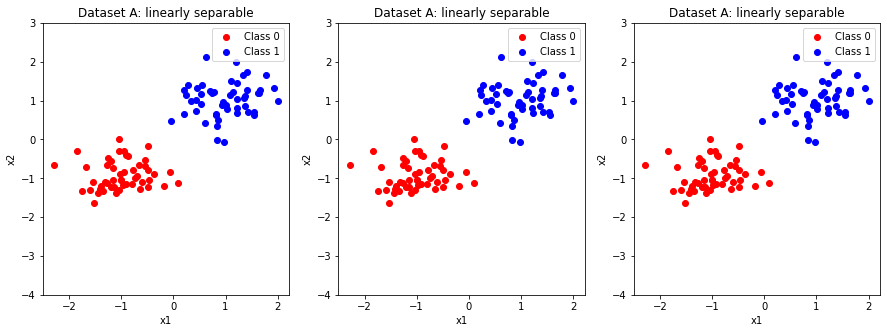

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

## TODO: Plot margin ledt and right, you can use linestyle="dashed"

[ax[i].set_ylim(-4, 3) for i in range(3)]
[plot_dataset(X_blobs1, y_blobs1, title="Dataset A: linearly separable", axes=ax[i]) for i in range(3)]

- 1.4 Let's compute the test error for each hyperplane. First define a function `clf_predict` that predicts the decisions for a given classifier: $\hat{y}(x) = \operatorname{sign}(\langle w, x \rangle + b)$. The function takes as input, the weight $w$ and bias $b$ of the hyperplane and features `X`. Use the `test_error` function you defined above to compute the test error for Classifier A, B, and C. Are the results in line with your observation?

In [10]:
def clf_predict(w, b, X): # returns 0, 1
    ## TODO: Implement the function that makes prediction given w, b and X
    pass

In [11]:
## TODO: Print error for A, B, C

# Hard-margin Support Vector Machine

We formalize a hard-margin SVM as 
\begin{align}
&\underset{w \in \mathbb{R}^d, b\in \mathbb{R}}{\min} \frac{1}{2} \| w \| ^ 2 \notag \\
&\text{subject to:} ~y_i (\langle w, x_i \rangle + b) \ge 1, \forall i=1,..,n \notag
\end{align}

The support vectors are the points on the margin, that is $\langle w, x \rangle + b = \pm 1$. The area between the two supporting hyperplanes $\{x \mid \langle w, x \rangle + b = 1\}$ and $\{x \mid \langle w, x \rangle + b = -1\}$ is called the margin.

- 1.5 Analyze the performance of a linear SVM. 

**TODO:**

a. Train an SVM model using the scikit-learn `SVC` model with a default value of `C=1000`. [Link](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

b. Compute the test error and plot the classification boundary.  

c. Print out the number of support vectors found.

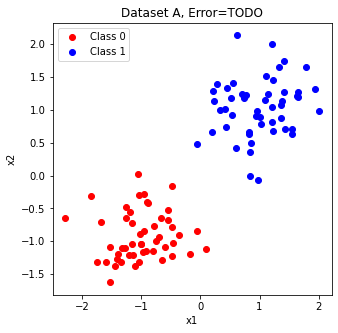

In [12]:
from sklearn.svm import SVC

## TODO: Fit the model

## TODO: Compute the error
error="TODO"

# Plot the dataset
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
plot_dataset(X_blobs1, y_blobs1, title=f"Dataset A, Error={error}", axes=ax)

## TODO: Plot decision boundary


- 1.6 In the lecture, we learned that modifications of the training points matter only if they fall into the margin/or on the wrong side of the decision boundary. Let's verify that using dataset A. 

a. Find a datapoint for each of the following cases and augment the dataset A with the datapoint. 

b. Analyze the performance of a linear SVM with `C=1000` on both the original and augmented dataset.

c. Compute the test error and plot the classification boundary with the support vectors.

**Scenerios to simulate**
- POINT A: correctly classified, outside the margin
- POINT B: exactly on the margin
- POINT C: correctly classified, inside margin
- POINT D: misclassified, inside the margin
- POINT E: misclassified, outside the margin

In [13]:
# Original dataset

## TODO: Fit the model

## TODO: Compute the test error
error_O="TODO"

# Print the error
print(f"Error on original dataset: {error_O}")

Error on original dataset: TODO


In [14]:
# For point A, B, C, D, E

## TODO: Define point and concatenate to X_blobs1 and y_blobs1

## TODO: Fit the model on augmented dataset

## TODO: Compute the test error


In [15]:
## TODO: Plot original dataset and the 5 different augmented datasets and the decision boundaries


## TODO (optional): Colour the added point in green for visibility

# 2. Overlapping Classes

Previously we have defined a hard-margin SVM. We now move to dataset B and explore why this is problematic and what a soft-margin SVM does.

## Soft-margin Support Vector Machine

We formalize a soft-margin SVM as 

\begin{align}
&\underset{\mathbf{w} \in \mathbb{R}^d, b \in \mathbb{R}, \mathbf{\xi} \in \mathbb{R}}{\min} \frac{1}{2} \| \mathbf{w} \|^2 + \frac{C}{n}\sum_{i=1}^n \xi_i \notag \\
&\text{subject to:}~Y_i(\langle \mathbf{w}, x_i \rangle + b) \ge 1 - \xi_i \quad \forall i = 1, ..., n, \notag \\
&\quad \quad \quad \quad \xi_i \ge 0, \quad \forall i = 1, ..., n \notag
\end{align}


Therefore, an SVM is trying two things simultaneously:
1. To find a hyperplane with the largest minimum margin
2. To find a hyperplane that correctly separates as many instances as possible. 

It is a trade-off and the parameter `C` allows us to determine how much to value one goal over the other.

- 1.7  What is the functionality of parameter `C`? Why did we choose in the previous example `C=1000`? Explore different values of the `C` parameter `[0,001, 0.01, 1, 10, 100, 1000]` for a linear SVM. Compute the test error and plot the classification boundary for each parameter value. Also, why did we not include `C=0`?


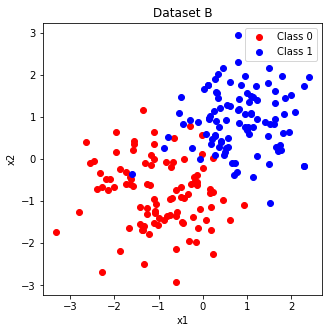

In [16]:
# Plot original dataset
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
plot_dataset(X_blobs2, y_blobs2, title="Dataset B", axes=ax)

In [17]:
# Plot different C for SVC values as given above 

## TODO: Fit the model

## TODO: Plot the dataset

## TODO: Plot the decision boundary

# 3. Non-linear problems

Untill now, we have seen linear separable and non-separable problems. We solved with a linear SVM with a soft margin. A linear SVM uses a kernel: $\langle x, x' \rangle$. We now move to dataset C and non-linear problems.

- 3.1 Analyze the performance of a linear SVM with value `C=10000` on dataset C. Compute the test erro and plot the classification boundary and support vectors. What do you observe?

In [18]:
## TODO: Fit the model

## TODO: Compute the test error

## TODO: Plot the dataset

## TODO: Plot the decision boundary

## Radial Basis Function (RBF) Kernel

We can use an SVM for non-linear problems by choosing a kernel that fits to our data. The radial basis function (RBF) kernel is defined as 

$$\operatorname{exp}\big(-\gamma \|x - x' \|^2\big)$$,

where $\gamma$ is specified by parameter gamma and must be greater than 0.

- 3.2 Before we move to solving non-linear problem with an SVM, let's compute a radial basis function centered on the middle clump. `r = np.exp(-(X**2).sum())`. Visualize the extra data dimension using a three-dimensional plot. HINT: Running the notebook live, you will be able to rotate the plot.


In [19]:
# Enabling the `wisget` backend.
# This requires jupyter-matplotlib aka ipympl
# ipympl can be installed via pip or conda

from mpl_toolkits.mplot3d import Axes3D
%matplotlib widget

## TODO: Code the radial basis function given above


## TODO: Concatenate it as third dimension to the dataset

## TODO: Plot the data with a 3D plot, color one class in red, and the other in blue


- 3.3 Train a non-linear SVM with an RBF kernel. Set `C=1` and explore different values of `gamma` parameter `[0.01, 0.1, 1, 10, 1000]`. Compute the test error and plot the classification boundary. Set `gamma=1` and explore different values of the `C` parameter `[0.01, 0.1, 1, 10, 100]`. Compute the test error and plot the classification boundary. What does a parameter `C<0`, `C=0`, and `C>1` mean?


In [20]:
# Sweep over C i.e for each value in C

## TODO: Fit the model

## TODO: Compute the test error

## TODO: Plot the dataset

## TODO: Plot the decision boundary


In [21]:
# Sweep over gamma i.e for each value in gamma

## TODO: Fit the model

## TODO: Compute the test error

## TODO: Plot the dataset

## TODO: Plot the decision boundary

# 4. Choosing Parameters

One of the limitations of SVMs is that there is the complexity paramerer `C` and for non-linear kernels, a paramerer previously called `gamma` that must be found using a hold-out method such as cross-validation (CV). Let's take a look at this together.

- Use a 5-fold CV (via `cross_val_score`, see [here](https://scikit-learn.org/stable/modules/cross_validation.html)) to adjust both `C` and `gamma` parameters of a RBF SVM for not linearly separable data. Explore values of `C` in  `[0.001, 0.01, 0.1, 0.1, 1, 10, 100, 1000]`, and define the range of `gamma` as `[0.125, 0.25, 0.5, 1, 2, 4, 8])/D` being `D` the data dimension. Note that this definition of the `gamma` values is used to alleviate the influence of the data dimension in the definition of the RBF kernel. Print mean and standard deviation of the scorse. Which model provides you the best results?

In [22]:
# For each combination of C and gamma

## TODO: Compute the cross validation score

## TODO: Print the mean and standard deviation

HINT: For futher information on the parameters and their trade-off, take a look [here](https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html_)

# 5. Different Kernels, Multiple Classsss

In addition to the linear and RBF kernel, scikit-learn also implements the following kernels for example

- polynomial: $(\gamma \langle x, x' \rangle + r)^d$, where $d$ is specified by parameter `degree`, $r$ by `coef0`
- sigmoid: $\operatorname{tanh}(\gamma \langle x, x' \rangle + r)$, where $r$ is specified by `coef0`

We will take a brief look at what and how their decision boundaries look like.

- Let's move to a multi-class dataset D and take a look at the decision boundaries of the different kernels. Analyze the performance of an SVM with `linear`, `rbf`(with `gamma=0.7`), `poly`(with `degree=3`, `gamma=auto`) kernels. For the sake of simplicity, you can use a default value of `C=1`. Compute the test error and plot the classification boundary. What does the gamma mean for each of the kernels?

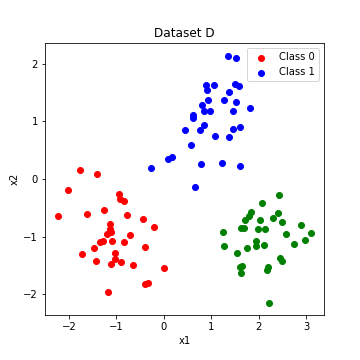

In [23]:
# Plot original dataset
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
y_two = y_blobs3==2
plot_dataset(X_blobs3, y_blobs3, title="Dataset D", axes=ax)
plt.scatter(X_blobs3[y_two, 0], X_blobs3[y_two, 1], color="green", axes=ax)
_ = ax.legend();

In [24]:
# from here: https://scikit-learn.org/stable/auto_examples/svm/plot_iris_svc.html
def make_meshgrid(x, y, h=0.02):
    # Create a mesh of points to plot in
    
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), 
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    # Plot the decision boundaries for a classfier.
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

In [25]:
## TODO: Define the four SVC models


# For each model
## TODO: Fit the model

## TODO: Compute the test error


# Set-up 2x2 grid for plotting. Check https://scikit-learn.org/stable/auto_examples/svm/plot_iris_svc.html


HINT: Not enough kernels to choose from? Interested in a DIY-kernel? Check [this](https://scikit-learn.org/stable/auto_examples/svm/plot_custom_kernel.html#sphx-glr-auto-examples-svm-plot-custom-kernel-py) out.

# 6. Further Considerations (self-study)

The following considerations are not study focus of this notebook but nonetheless important.

- unbalanced classes: [here](https://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane_unbalanced.html#sphx-glr-auto-examples-svm-plot-separating-hyperplane-unbalanced-py)
- weighted samples: [here](https://scikit-learn.org/stable/auto_examples/svm/plot_weighted_samples.html#sphx-glr-auto-examples-svm-plot-weighted-samples-py)
- one-versus-rest-multi-class approach: [here](https://scikit-learn.org/stable/auto_examples/svm/plot_iris_svc.html#sphx-glr-auto-examples-svm-plot-iris-svc-py)
- SVMs on hand written digits: [here](https://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html)
- SVMs with different kernels vs Logisitc Regression: [here](https://dmkothari.github.io/Machine-Learning-Projects/SVM_with_MNIST.html)
- SVMs with Neural Nets (NN): [here](https://www.researchgate.net/post/Which-is-more-accurate-Neural-Networks-NNsor-support-vector-machineSVM)

### Credit
This notebook was created by UdS ML21 tutors and modified by ML22 team. Thanks to Miriam Rateike and team.